In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kstest,ttest_ind
import itertools as it
from collections import Counter
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages
from functools import reduce
from scipy.stats import kstest,ttest_ind

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return



In [3]:
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
cohort_file = "/data6/deepro/ukb_bmi/3_characterization/data/combos_in_cohort/british/train_cohort.csv"

In [4]:
phenotype_df = pd.read_csv(phenotype_file, usecols=["sample_names", "bmi", "bmi_prs"])
phenotype_df["bmi_decile"] = pd.qcut(phenotype_df.bmi, q=10)

cohort_df = pd.read_csv(cohort_file)
all_combo_samples = set("|".join(cohort_df.combo_samples.values).split("|"))

In [5]:
len(all_combo_samples)

14267

In [6]:
phenotype_combo_samples_df = phenotype_df.loc[phenotype_df.sample_names.astype(str).isin(list(map(str, all_combo_samples)))]
phenotype_other_samples_df = phenotype_df.loc[~phenotype_df.sample_names.astype(str).isin(list(map(str, all_combo_samples)))]

In [7]:
phenotype_other_samples_df["description"] = "Non Combo"
phenotype_combo_samples_df["description"] = "Combo"
phenotype_samples_df = pd.concat((phenotype_combo_samples_df, phenotype_other_samples_df))

/tmp/ipykernel_19586/1284634724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_other_samples_df["description"] = "Non Combo"
/tmp/ipykernel_19586/1284634724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_combo_samples_df["description"] = "Combo"


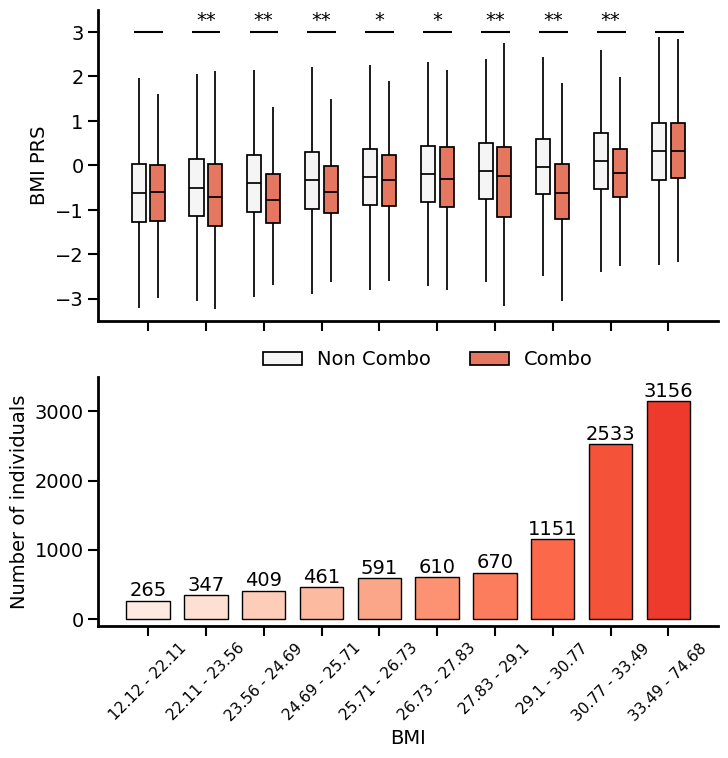

In [8]:
def create_decile_rank_plot(phenotype_samples_df):
    fig,ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True, height_ratios=(5, 4))
    ## BMI prs box plots
    sns_ax = sns.boxplot(
        phenotype_samples_df, x="bmi_decile", y="bmi_prs", hue="description", hue_order=["Non Combo", "Combo"],
        width=0.65, linewidth=1.25, fliersize=0, capprops={'color':'none'}, boxprops={'edgecolor':'k'},
        medianprops={'color':'k'},
        linecolor='k',
        palette= ["whitesmoke", sns.color_palette("Reds", 15).as_hex()[7]],
        legend=True, gap=0.25, ax=ax[0])
    ax[0].set_ylim(-3.5, 3.5)
    ax[0].spines[['right', 'top']].set_visible(False)
    ax[0].hlines([3 for i in range(10)], [(i-0.25+i*0.001953125) for i in range(0, 10)], [(i+0.25+i*0.001953125) for i in range(0,10)], color="k")
    for i, (psdi, psd) in enumerate(phenotype_samples_df.groupby("bmi_decile", observed=False)):
        ttest_res = ttest_ind(psd.loc[psd.description=="Combo", "bmi_prs"], psd.loc[psd.description=="Non Combo", "bmi_prs"], alternative="less")
        ttest_pval = ttest_res.pvalue
        if ttest_pval<0.05:
            pval_text = "*"
            if ttest_pval<0.001:
                pval_text = "**"
                # pval_text = f"P = {ttest_pval:.1E}"
            ax[0].text(0.+i, 3.05, pval_text, ha="center", va="bottom", fontsize=14)
    h,l = ax[0].get_legend_handles_labels()
    ax[0].legend_.remove()
    fig.legend(h,l, ncol=2, loc=(0.35, 0.5025), frameon=False)
    ax[0].set_ylabel("BMI PRS")
    
    phenotype_combo_samples_decile_df = phenotype_samples_df.loc[phenotype_samples_df.description=="Combo"].groupby("bmi_decile", observed=True).agg({
        "sample_names": "count",
        "bmi_prs": "median",
        "bmi": "mean"}
        ).reset_index()
    phenotype_combo_samples_decile_df["decile_rank"] = range(10)
    decile_labels =  [" - ".join([str(round(v.left, 2)),str(round(v.right, 2))]) for v in  phenotype_combo_samples_decile_df.bmi_decile.values]

    ## Combo per decile barplot
    ax[1].bar(phenotype_combo_samples_decile_df.decile_rank, phenotype_combo_samples_decile_df.sample_names, width=0.75, color=sns.color_palette("Reds", 15).as_hex()[:10], edgecolor="k")
    xticklabels = decile_labels
    ax[1].set_xticks(range(10), xticklabels, rotation=45, ha="center", fontsize=11)
    ax[1].set_xlabel("BMI")
    ax[1].set_ylabel("Number of individuals")
    # g.bar_label([g.containers[i] for i in range])
    rects = ax[1].patches
    # Make some labels.
    for rect in rects:
        height = rect.get_height()
        ax[1].text(
            rect.get_x() + rect.get_width() / 2, height + 5, f"{height}", ha="center", va="bottom"
        )
    ax[1].set_ylim(-100, 3500)
    ax[1].spines[['right', 'top']].set_visible(False)

    return fig,ax

fig, ax = create_decile_rank_plot(
    phenotype_samples_df
    )